# Imports

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import sys
import torch
import torchvision
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [13]:
def get_device(use_gpu=True):
    return torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")

def to_device(items, device):
    return [item.to(device) for item in items]

def to_tensor(items, types):
    tensors = []
    for i in range(len(items)):
        if isinstance(items[i], torch.Tensor):
            tensors += items[i]
        elif isinstance(items[i], np.ndarray):
            if isinstance(types, list):
                tensors += [torch.tensor(items[i], dtype=types[i])]
            else:
                tensors += [torch.tensor(items[i], dtype=types)]
        else:
            raise NotImplementedError()
    return tensors

def to_ndarray(items):
    ndarrays = []
    for item in items:
        if isinstance(item, torch.Tensor):
            ndarrays += [item.detach().cpu().numpy()]
        elif isinstance(item, np.ndarray):
            ndarrays += [item]
        elif isinstance(item, list):
            ndarrays += [np.array(item)]
        else:
            raise NotImplementedError()
    return ndarrays

def get_accuracy(Yhat, Y):
    if isinstance(Yhat, torch.Tensor) and isinstance(Y, torch.Tensor):
        _, preds = Yhat.max(dim=1)
        n_correct = preds.eq(Y).sum().item()
    elif isinstance(Yhat, np.ndarray) and isinstance(Y, np.ndarray):
        preds = np.argmax(Yhat, axis=-1)
        n_correct = len(np.where(preds == Y)[0])
    return n_correct / len(Y) * 100

def get_confusion(Yhat, Y):
    preds = np.argmax(Yhat, axis=-1)
    return confusion_matrix(Y, preds)

def plot_model_accuracies(model, show=[1,2,3], ylim=[95, 100.1]):
    plt.figure(figsize=(15,10))
    if 1 in show:
        plt.plot(model.train_accs, color="k", label="training")
    if 2 in show:
        plt.plot(model.valid_accs, color="r", label="validation")
    if 3 in show:
        plt.plot(model.test_accs, color="g", label="testing")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.ylim(ylim[0], ylim[1])
    plt.xlim(-1, len(model.train_accs)+1)
    plt.legend()
    plt.show()
    plt.close()
    
def plot_model_losses(model, show=[1,2,3]):
    plt.figure(figsize=(15,10))
    if 1 in show:
        plt.plot(model.train_losses, color="k", label="training")
    if 2 in show:
        plt.plot(model.valid_losses, color="r", label="validation")
    if 3 in show:
        plt.plot(model.test_losses, color="g", label="testing")
    plt.ylabel("Cross Entropy Loss")
    plt.xlabel("Epoch")
    #plt.ylim(95, 100.1)
    plt.xlim(-1, len(model.train_accs)+1)
    plt.legend()
    plt.show()
    plt.close()
    
def plot_confusion(Yhat, Y):
    n_classes = np.unique(Y).shape[0]
    mat = get_confusion(test_Yhat, test_Y)
    plt.figure(figsize=(10,10))
    plt.imshow(mat, extent=[-0.5, n_classes-1+0.5, -0.5, n_classes-1+0.5], origin="upper")
    plt.ylabel("True Class")
    plt.title("Predicted Class")
    plt.yticks(np.arange(n_classes))
    plt.xticks(np.arange(n_classes))
    for j in range(mat.shape[0]):
        for k in range(mat.shape[1]):
            plt.text(j, k, mat[mat.shape[0]-k-1,j], ha="center", va="center")
    plt.show()
    plt.close()

act_func_map = {
    "relu": torch.nn.functional.relu, 
    "tanh": torch.nn.functional.tanh, 
    "sigmoid": torch.sigmoid, 
    "identity": lambda x:x,
    "log_softmax": torch.nn.functional.log_softmax,
}
opt_func_map = {
    "sgd": torch.optim.SGD, 
    "rmsprop": torch.optim.RMSprop,
    "rprop": torch.optim.Rprop,
    "adadelta": torch.optim.Adadelta,
    "adam": torch.optim.Adam
}
init_func_map = {
    "constant": torch.nn.init.constant_,
    "normal": torch.nn.init.normal_, 
    "xavier": torch.nn.init.xavier_normal_, 
    "kaiming": torch.nn.init.kaiming_normal_,
}
loss_func_map = {
    "mae": torch.nn.L1Loss, 
    "mse": torch.nn.MSELoss, 
    "smooth_mae": torch.nn.SmoothL1Loss,
    "nll": torch.nn.NLLLoss,
}

In [14]:
train = torchvision.datasets.MNIST(
    "data",
    train=True,
    download=True
)
test = torchvision.datasets.MNIST(
    "data",
    train=False,
    download=True
)
train_X = train.data.numpy()
train_Y = train.targets.numpy()
np.random.seed(123)
selection = np.random.choice(train_X.shape[0], size=train_X.shape[0]//10, replace=False)
valid_X = train_X[selection,:]
valid_Y = train_Y[selection]
train_X = np.delete(train_X, selection, axis=0)
train_Y = np.delete(train_Y, selection, axis=0)
test_X = test.data.numpy()
test_Y = test.targets.numpy()
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1], train_X.shape[2]))
valid_X = np.reshape(valid_X, (valid_X.shape[0], 1, valid_X.shape[1], valid_X.shape[2]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1], test_X.shape[2]))
print(train_X.shape)
print(train_Y.shape)
print(valid_X.shape)
print(valid_Y.shape)
print(test_X.shape)
print(test_Y.shape)
train_X = (train_X / 255 - 0.5) * 2
valid_X = (valid_X / 255 - 0.5) * 2
test_X = (test_X / 255 - 0.5) * 2
n_channels, height, width = train_X.shape[1], train_X.shape[2], train_X.shape[3]
n_classes = len(np.unique(train_Y))

(54000, 1, 28, 28)
(54000,)
(6000, 1, 28, 28)
(6000,)
(10000, 1, 28, 28)
(10000,)


In [15]:
class CNN(torch.nn.Module):
    
    def __init__(self, n_channels, height, width, n_responses):
        super(CNN, self).__init__()
        in_width, in_width, = height, width
        in_channels, out_channels = n_channels, 12
        kernel_size, stride = (5, 5), (2, 2)
        self.layer_1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        in_width, in_height = self.get_conv2d_output_heightwidth(in_channels, out_channels, kernel_size, stride)
        in_channels, out_channels = out_channels, 12
        kernel_size, stride = (5, 5), (2, 2)
        self.layer_2 = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        in_width, in_height = self.get_conv2d_output_heightwidth(in_channels, out_channels, kernel_size, stride)
        in_channels = out_channels
        self.layer_3 = torch.nn.Flatten()
        self.layer_4 = torch.nn.Linear(in_channels*in_width*in_height, 30)
        self.layer_5 = torch.nn.Linear(30, n_responses)
        
    def forward(self, X):
        a = X
        z = self.layer_1(a)
        a = act_func_map["relu"](z)
        z = self.layer_2(a)
        a = act_func_map["relu"](z)
        z = self.layer_3(a)
        a = act_func_map["identity"](z)
        z = self.layer_4(a)
        a = act_func_map["relu"](z)
        z = self.layer_5(a)
        a = act_func_map["log_softmax"](z, dim=1)
        return a
    
    def optimize(self, train, valid=None, test=None, lr=0.05, mo=0.9, early_stop_epochs=10, n_epochs=100, mbatch_size=256, 
                 loss="nll", opt="sgd", batch_shuf_seed=1, init="xavier", init_seed=1):
#        torch.cuda.empty_cache()
        device = get_device()
        self = to_device([self], device)[0]
        train = to_device(to_tensor(train, [torch.float, torch.long]), device)
        train_X, train_Y = train[0], train[1]
        if valid is not None:
            valid = to_device(to_tensor(valid, [torch.float, torch.long]), device)
            valid_X, valid_Y = valid[0], valid[1]
        if test is not None:
            test = to_device(to_tensor(test, [torch.float, torch.long]), device)
            test_X, test_Y = test[0], test[1]
        # Initialize loss, optimizer, and parameters
        self.crit = loss_func_map[loss]()
        if opt == "adam":
            self.opt = opt_func_map[opt](self.parameters(), lr=lr, betas=(mo, 0.999))
        elif opt == "nest":
            self.opt = opt_func_map["sgd"](self.parameters(), lr=lr, momentum=mo, nesterov=True)
        elif opt == "adadelta":
            self.opt = opt_func_map["adadelta"](self.parameters(), lr=lr)
        else:
            self.opt = opt_func_map[opt](self.parameters(), lr=lr, momentum=mo)
        self.init_params(init, init_seed)
        # Commence optimization
        n_mbatches = train_X.shape[0] // mbatch_size
        if batch_shuf_seed > -1:
            np.random.seed(batch_shuf_seed)
        self.train_losses, self.valid_losses, self.test_losses = [], [], []
        self.train_accs, self.valid_accs, self.test_accs = [], [], []
        min_valid_loss, max_valid_acc = sys.float_info.max, sys.float_info.min
        n_plateau_epochs = 0
        for epoch in range(n_epochs+1):
            selection = np.random.choice(train_X.shape[0], size=train_X.shape[0], replace=False)
            train_loss = 0
            self.train()
            # Step through minibatches
            for mbatch in range(n_mbatches):
                start = mbatch * mbatch_size
                end = (mbatch + 1) * mbatch_size
                mbatch_Yhat = self(train_X[selection[start:end]])
                mbatch_loss = self.crit(mbatch_Yhat, train_Y[selection[start:end]])
                # Gradient descent step
                self.opt.zero_grad()
                mbatch_loss.backward()
                self.opt.step()
                train_loss += mbatch_loss.item()
            train_loss /= n_mbatches
            self.eval()
            train_acc = get_accuracy(self(train_X), train_Y)
            print("Epoch %d : Training Loss/Accuracy   = %.3f/%.3f" % (epoch, train_loss, train_acc))
            self.train_losses += [train_loss]
            self.train_accs += [train_acc]
            if valid is not None:
                valid_Yhat = self(valid_X)
                valid_loss = self.crit(valid_Yhat, valid_Y).item()
                valid_acc = get_accuracy(valid_Yhat, valid_Y)
                print("Epoch %d : Validation Loss/Accuracy = %.3f/%.3f" % (epoch, valid_loss, valid_acc))
                self.valid_losses += [valid_loss]
                self.valid_accs += [valid_acc]
                if valid_acc <= max_valid_acc:
                    n_plateau_epochs += 1
                else:
                    n_plateau_epochs = 0
                    max_valid_acc = valid_acc
            if test is not None:
                test_Yhat = self(test_X)
                test_loss = self.crit(test_Yhat, test_Y).item()
                test_acc = get_accuracy(test_Yhat, test_Y)
                print("Epoch %d : Testing Loss/Accuracy    = %.3f/%.3f" % (epoch, test_loss, test_acc))
                self.test_losses += [test_loss]
                self.test_accs += [test_acc]
            for param_group in self.opt.param_groups:
                param_group["lr"] = lr * 0.9**(epoch//10)
            print("############################################################")
            if n_plateau_epochs >= early_stop_epochs:
                print("Stopping early!")
                break
        device = get_device(False)
        self = to_device([self], device)[0]
        train = to_ndarray(train)
        if valid is not None:
            valid = to_ndarray(valid)
        if test is not None:
            test = to_ndarray(test)
            
    def predict(self, X):
        self.eval()
        device = get_device()
        self = to_device([self], device)[0]
        X = to_device(to_tensor([X], [torch.float]), device)[0]
        Yhat = self(X)
        device = get_device(False)
        self = to_device([self], device)[0]
        data = to_ndarray([X, Yhat])
        X, Yhat = data[0], data[1]
        return Yhat
    
    def init_params(self, init, seed=-1):
        if seed > -1:
            torch.manual_seed(seed)
        for name, param in self.named_parameters():
            if "bias" in name:
                init_func_map["constant"](param, 0.0)
            elif "weight" in name:
                init_func_map[init](param)
    
    def get_conv2d_output_heightwidth(self, H_in, W_in, kernel_size, stride, padding=(0, 0), dilation=(1, 1)):
        H_out = int((H_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
        W_out = int((W_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)
        return H_out, W_out

In [16]:
model = CNN(n_channels, height, width, n_classes)
model.optimize([train_X, train_Y], [valid_X, valid_Y], [test_X, test_Y], mbatch_size=1024, opt="adadelta")

Epoch 0 : Training Loss/Accuracy   = 2.211/33.706
Epoch 0 : Validation Loss/Accuracy = 2.029/33.333
Epoch 0 : Testing Loss/Accuracy    = 2.023/34.060
############################################################
Epoch 1 : Training Loss/Accuracy   = 1.514/73.520
Epoch 1 : Validation Loss/Accuracy = 0.947/73.600
Epoch 1 : Testing Loss/Accuracy    = 0.917/74.910
############################################################
Epoch 2 : Training Loss/Accuracy   = 0.735/81.076
Epoch 2 : Validation Loss/Accuracy = 0.606/80.883
Epoch 2 : Testing Loss/Accuracy    = 0.584/82.010
############################################################
Epoch 3 : Training Loss/Accuracy   = 0.555/84.543
Epoch 3 : Validation Loss/Accuracy = 0.507/84.567
Epoch 3 : Testing Loss/Accuracy    = 0.491/85.260
############################################################
Epoch 4 : Training Loss/Accuracy   = 0.483/86.141
Epoch 4 : Validation Loss/Accuracy = 0.456/86.183
Epoch 4 : Testing Loss/Accuracy    = 0.441/86.870
######

Epoch 39 : Training Loss/Accuracy   = 0.173/94.972
Epoch 39 : Validation Loss/Accuracy = 0.170/94.967
Epoch 39 : Testing Loss/Accuracy    = 0.157/95.320
############################################################
Epoch 40 : Training Loss/Accuracy   = 0.170/95.024
Epoch 40 : Validation Loss/Accuracy = 0.168/94.800
Epoch 40 : Testing Loss/Accuracy    = 0.153/95.390
############################################################
Epoch 41 : Training Loss/Accuracy   = 0.167/95.083
Epoch 41 : Validation Loss/Accuracy = 0.165/94.900
Epoch 41 : Testing Loss/Accuracy    = 0.150/95.490
############################################################
Epoch 42 : Training Loss/Accuracy   = 0.165/95.241
Epoch 42 : Validation Loss/Accuracy = 0.161/95.150
Epoch 42 : Testing Loss/Accuracy    = 0.149/95.520
############################################################
Epoch 43 : Training Loss/Accuracy   = 0.163/95.313
Epoch 43 : Validation Loss/Accuracy = 0.159/95.233
Epoch 43 : Testing Loss/Accuracy    = 0.14

Epoch 78 : Training Loss/Accuracy   = 0.113/96.759
Epoch 78 : Validation Loss/Accuracy = 0.114/96.650
Epoch 78 : Testing Loss/Accuracy    = 0.103/96.920
############################################################
Epoch 79 : Training Loss/Accuracy   = 0.112/96.772
Epoch 79 : Validation Loss/Accuracy = 0.113/96.667
Epoch 79 : Testing Loss/Accuracy    = 0.102/96.970
############################################################
Epoch 80 : Training Loss/Accuracy   = 0.112/96.793
Epoch 80 : Validation Loss/Accuracy = 0.113/96.683
Epoch 80 : Testing Loss/Accuracy    = 0.102/96.980
############################################################
Epoch 81 : Training Loss/Accuracy   = 0.111/96.802
Epoch 81 : Validation Loss/Accuracy = 0.113/96.633
Epoch 81 : Testing Loss/Accuracy    = 0.101/96.870
############################################################
Epoch 82 : Training Loss/Accuracy   = 0.110/96.807
Epoch 82 : Validation Loss/Accuracy = 0.111/96.717
Epoch 82 : Testing Loss/Accuracy    = 0.10

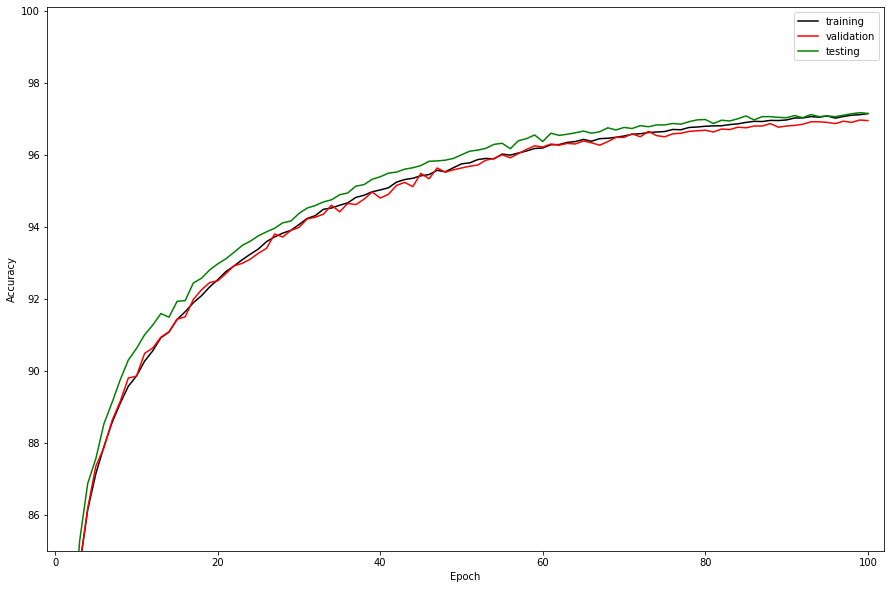

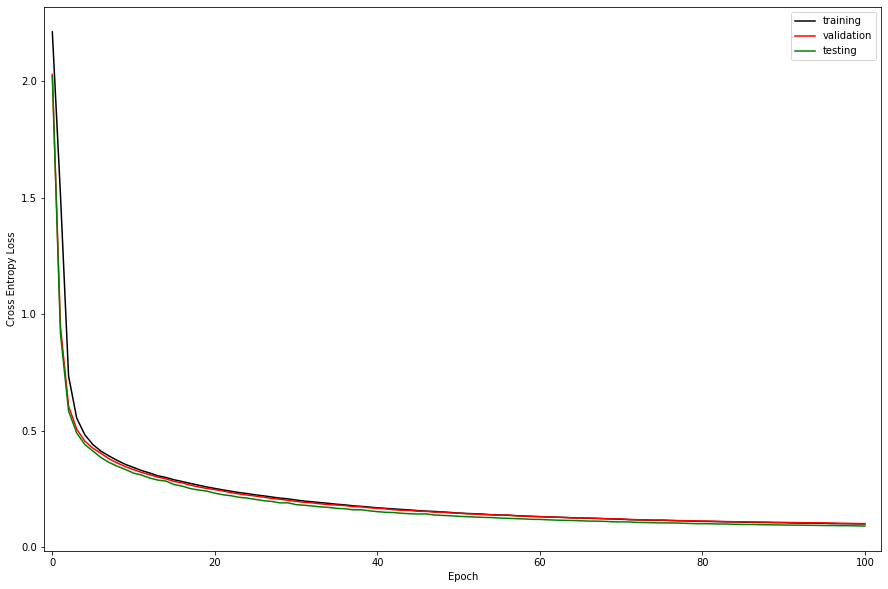

Train Accuracy:      97.14%
Validation Accuracy: 96.95%
Test Accuracy:       97.15%


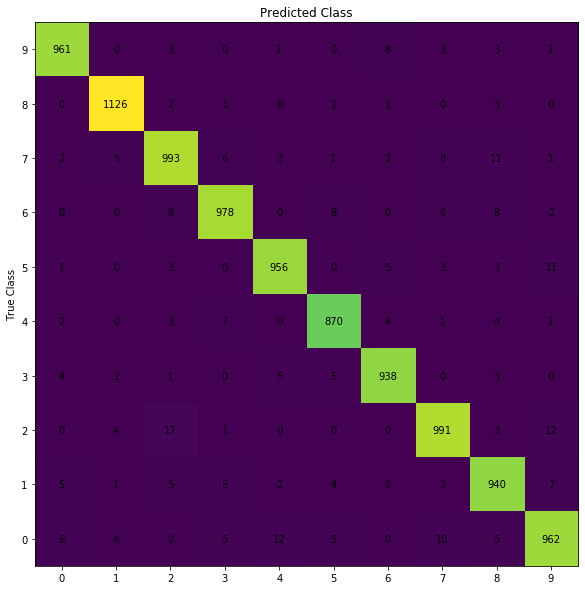

In [19]:
plot_model_accuracies(model, show=[1,2,3], ylim=[85,100.1])
plot_model_losses(model, show=[1,2,3])
train_Yhat = model.predict(train_X)
valid_Yhat = model.predict(valid_X)
test_Yhat = model.predict(test_X)
train_acc = get_accuracy(train_Yhat, train_Y)
print("Train Accuracy:      %.2f%%" % (train_acc))
valid_acc = get_accuracy(valid_Yhat, valid_Y)
print("Validation Accuracy: %.2f%%" % (valid_acc))
test_acc = get_accuracy(test_Yhat, test_Y)
print("Test Accuracy:       %.2f%%" % (test_acc))
plot_confusion(test_Yhat, test_Y)

In [20]:
model = CNN(n_channels, height, width, n_classes)
model.optimize([train_X, train_Y], [valid_X, valid_Y], [test_X, test_Y], mbatch_size=1024, opt="adam")

Epoch 0 : Training Loss/Accuracy   = 1.126/91.204
Epoch 0 : Validation Loss/Accuracy = 0.311/90.967
Epoch 0 : Testing Loss/Accuracy    = 0.304/91.460
############################################################
Epoch 1 : Training Loss/Accuracy   = 0.252/94.330
Epoch 1 : Validation Loss/Accuracy = 0.212/93.750
Epoch 1 : Testing Loss/Accuracy    = 0.188/94.490
############################################################
Epoch 2 : Training Loss/Accuracy   = 0.164/95.520
Epoch 2 : Validation Loss/Accuracy = 0.170/95.100
Epoch 2 : Testing Loss/Accuracy    = 0.160/95.130
############################################################
Epoch 3 : Training Loss/Accuracy   = 0.131/96.365
Epoch 3 : Validation Loss/Accuracy = 0.146/95.717
Epoch 3 : Testing Loss/Accuracy    = 0.137/96.110
############################################################
Epoch 4 : Training Loss/Accuracy   = 0.137/94.906
Epoch 4 : Validation Loss/Accuracy = 0.213/94.483
Epoch 4 : Testing Loss/Accuracy    = 0.200/94.810
######

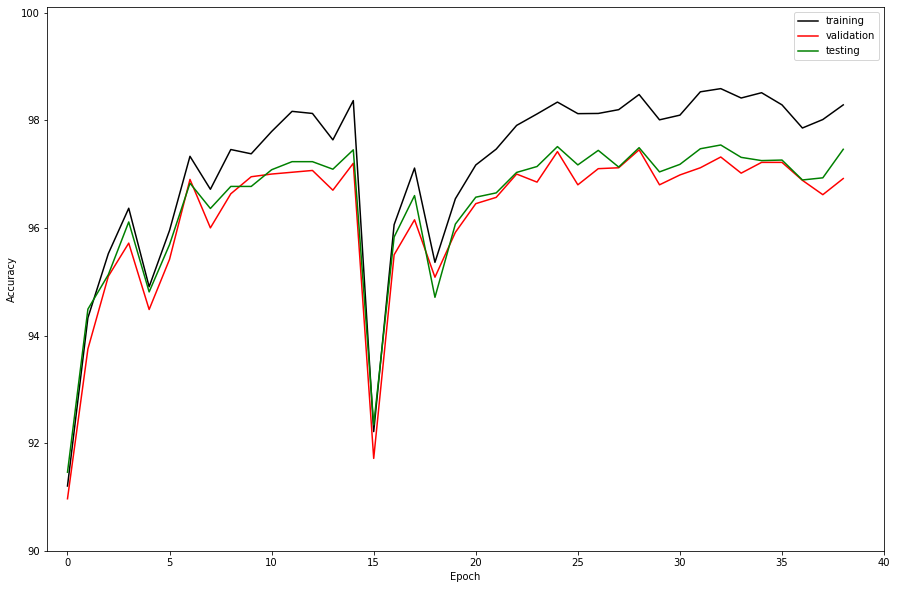

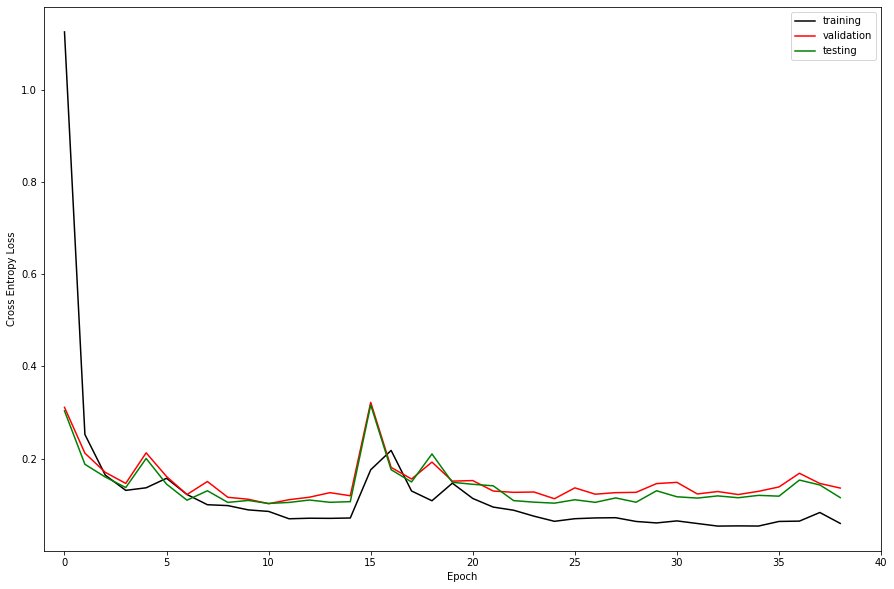

Train Accuracy:      98.29%
Validation Accuracy: 96.92%
Test Accuracy:       97.46%


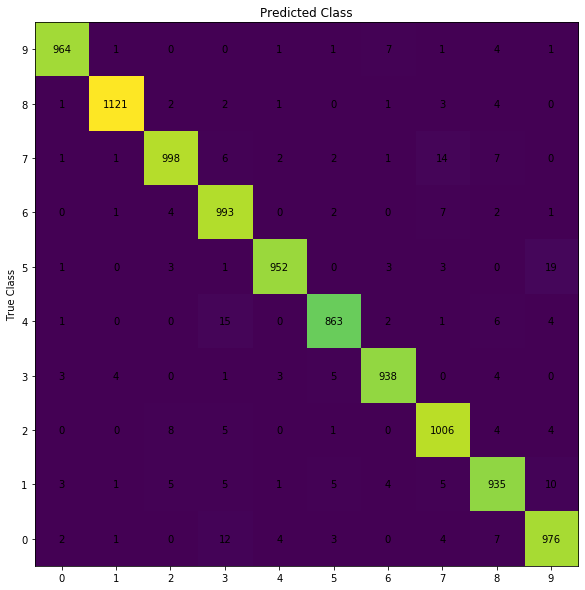

In [24]:
plot_model_accuracies(model, show=[1,2,3], ylim=[90, 100.1])
plot_model_losses(model, show=[1,2,3])
train_Yhat = model.predict(train_X)
valid_Yhat = model.predict(valid_X)
test_Yhat = model.predict(test_X)
train_acc = get_accuracy(train_Yhat, train_Y)
print("Train Accuracy:      %.2f%%" % (train_acc))
valid_acc = get_accuracy(valid_Yhat, valid_Y)
print("Validation Accuracy: %.2f%%" % (valid_acc))
test_acc = get_accuracy(test_Yhat, test_Y)
print("Test Accuracy:       %.2f%%" % (test_acc))
plot_confusion(test_Yhat, test_Y)

In [25]:
model = CNN(n_channels, height, width, n_classes)
model.optimize([train_X, train_Y], [valid_X, valid_Y], [test_X, test_Y], mbatch_size=1024, opt="nest")

Epoch 0 : Training Loss/Accuracy   = 1.189/89.598
Epoch 0 : Validation Loss/Accuracy = 0.327/89.967
Epoch 0 : Testing Loss/Accuracy    = 0.317/90.190
############################################################
Epoch 1 : Training Loss/Accuracy   = 0.245/94.594
Epoch 1 : Validation Loss/Accuracy = 0.177/94.750
Epoch 1 : Testing Loss/Accuracy    = 0.169/94.920
############################################################
Epoch 2 : Training Loss/Accuracy   = 0.159/96.063
Epoch 2 : Validation Loss/Accuracy = 0.128/96.183
Epoch 2 : Testing Loss/Accuracy    = 0.121/96.250
############################################################
Epoch 3 : Training Loss/Accuracy   = 0.121/97.015
Epoch 3 : Validation Loss/Accuracy = 0.102/97.000
Epoch 3 : Testing Loss/Accuracy    = 0.097/96.950
############################################################
Epoch 4 : Training Loss/Accuracy   = 0.099/97.330
Epoch 4 : Validation Loss/Accuracy = 0.096/97.083
Epoch 4 : Testing Loss/Accuracy    = 0.086/97.170
######

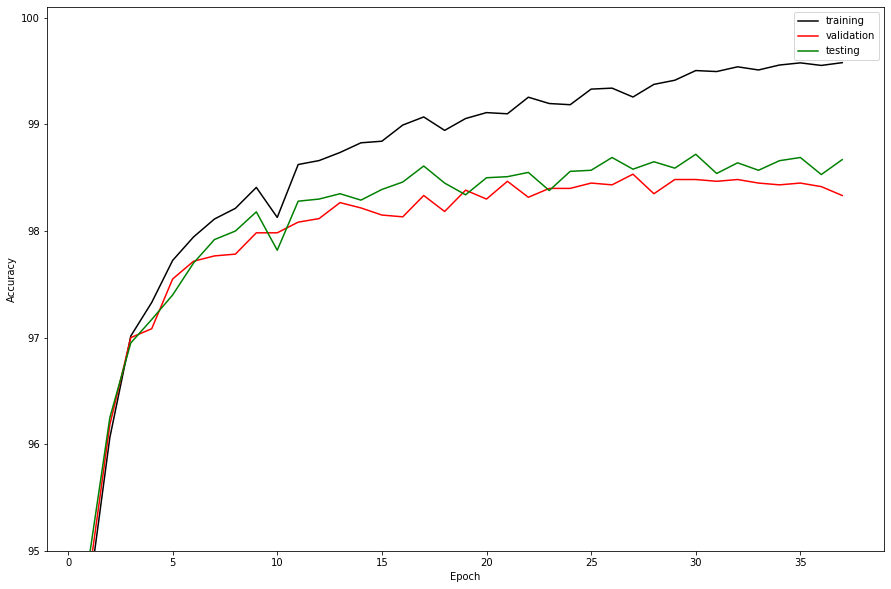

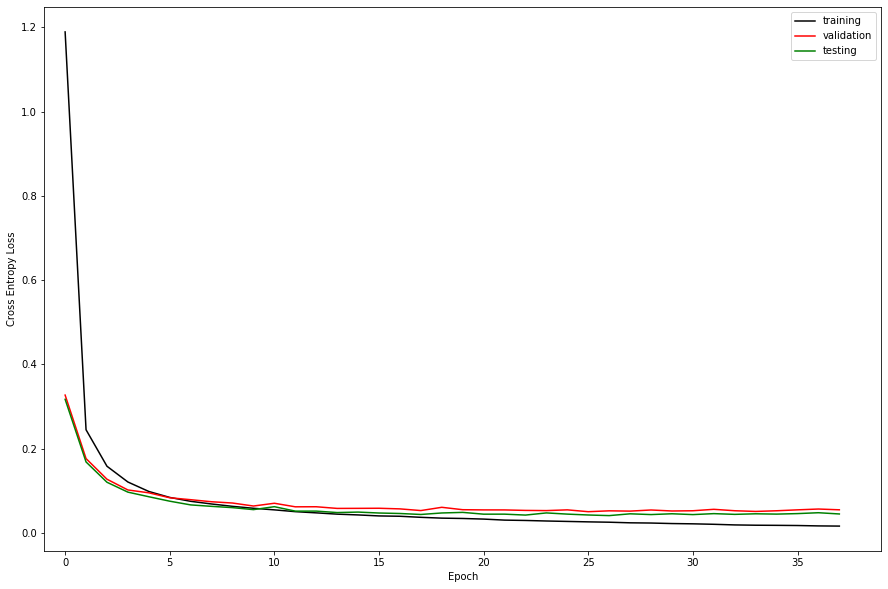

Train Accuracy:      99.58%
Validation Accuracy: 98.33%
Test Accuracy:       98.67%


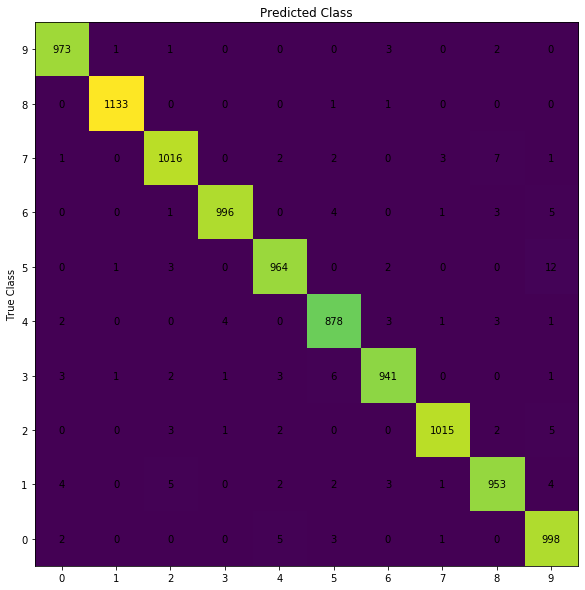

In [26]:
plot_model_accuracies(model, show=[1,2,3])
plot_model_losses(model, show=[1,2,3])
train_Yhat = model.predict(train_X)
valid_Yhat = model.predict(valid_X)
test_Yhat = model.predict(test_X)
train_acc = get_accuracy(train_Yhat, train_Y)
print("Train Accuracy:      %.2f%%" % (train_acc))
valid_acc = get_accuracy(valid_Yhat, valid_Y)
print("Validation Accuracy: %.2f%%" % (valid_acc))
test_acc = get_accuracy(test_Yhat, test_Y)
print("Test Accuracy:       %.2f%%" % (test_acc))
plot_confusion(test_Yhat, test_Y)